In [1]:
#!pip install xlrd

In [2]:
import os
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [3]:
def transform_guzmart(df):
    df['fecha_corte'] = pd.to_datetime(df['fecha_corte'])
    df['fecha_inicio'] = pd.to_datetime(df['fecha_inicio'])
    return df

def get_guzmart(date, force=False):
    sdate = date.strftime('%Y%m%d')
    fname = f"covid_mex_{sdate}"
    local_fname = f"data/guzmart/{fname}.h5"
    if not force and os.path.isfile(local_fname):
        df = pd.read_hdf(local_fname, 'df')
    else:
        url = f"https://github.com/guzmart/covid19_mex/raw/master/01_datos/covid_mex_{sdate}.xlsx"
        df = pd.read_excel(url)
        df = transform_guzmart(df)
        #guardar version csv y hdf
        csv_fname = f"data/guzmart/{fname}.csv"
        df.to_csv(csv_fname)
        df.to_hdf(local_fname, 'df')
    return df

In [4]:
def transform_johns_hopkins(df):
    df = df.groupby('Country/Region').sum()
    cols = list(df.columns)
    cols.remove('Lat')
    cols.remove('Long')
    df = df[cols]
    df = df.transpose()
    df.index = pd.to_datetime(df.index, format='%m/%d/%y')
    df.index.name = "Date"
    return df#[columns]

def get_johns_hopkins():
    url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(url)
    df = transform_johns_hopkins(df)
    fname = f"data/CSSEGUSandData/time_series_covid19_confirmed_global.csv"
    df.to_csv(fname)
    return df

# Mundo

In [5]:
dfw = get_johns_hopkins()
dfw.head(10)

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,2,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,2,0,0,0
2020-01-28,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,2,0,0,0
2020-01-29,0,0,0,0,0,0,0,0,6,0,...,0,4,0,0,0,0,2,0,0,0
2020-01-30,0,0,0,0,0,0,0,0,9,0,...,0,4,0,0,0,0,2,0,0,0


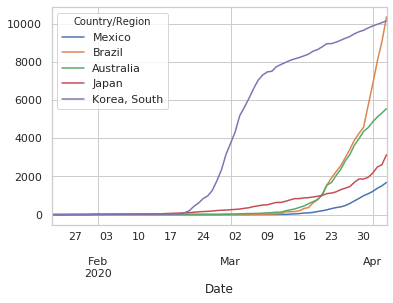

In [6]:
dfw[["Mexico", "Brazil", "Australia", "Japan", "Korea, South"]].plot(logy=False)

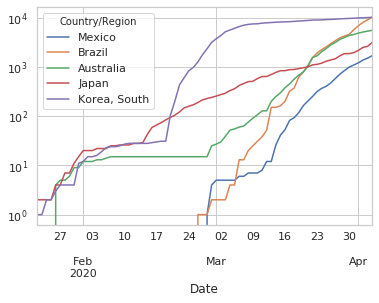

In [7]:
dfw[["Mexico", "Brazil", "Australia", "Japan", "Korea, South"]].plot(logy=True)

In [8]:
new_per_day = {}
for country in dfw.columns:
    d = dfw[country]
    dif = [d[i] - d[i-1] for i in range(1,len(d))]
    new_per_day[country] = dif
    
df_new_per_day = pd.DataFrame(new_per_day)
df_new_per_day.index = dfw.index[1:]
df_new_per_day.head()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-27,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


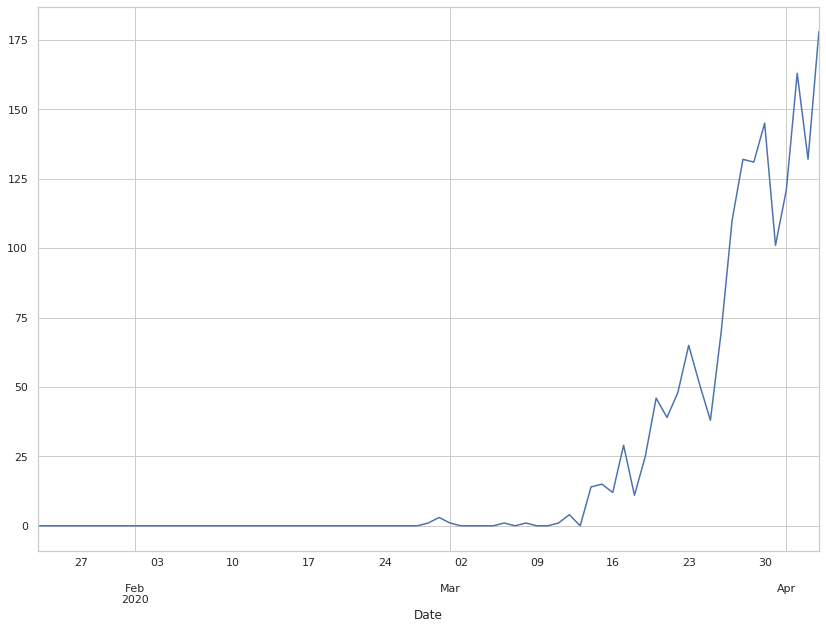

In [9]:
f, ax = plt.subplots(figsize=(14, 10))
df_new_per_day['Mexico'].plot()

In [10]:
def calculate_new_per_period(df_new_per_day, PERIOD=7):
    new_per_period = {}
    for country in df_new_per_day.columns:
        d = df_new_per_day[country]
        cum = [sum(d[(i-PERIOD):i]) for i in range(PERIOD, len(d))]
        new_per_period[country] = cum
    return new_per_period

In [11]:
def cum_and_new_from_init(dfw, new_per_period, country, INIT=99):
    d = dfw[country]
    cum_from_init = d[d>INIT]
    new_from_init = new_per_period[country][-len(cum_from_init):]
    assert len(cum_from_init) == len(new_from_init)
    return cum_from_init, new_from_init

In [12]:
dfw.columns[dfw.columns.str.contains("Korea")]

Index(['Korea, South'], dtype='object', name='Country/Region')

Text(0, 0.5, 'new cases last days')

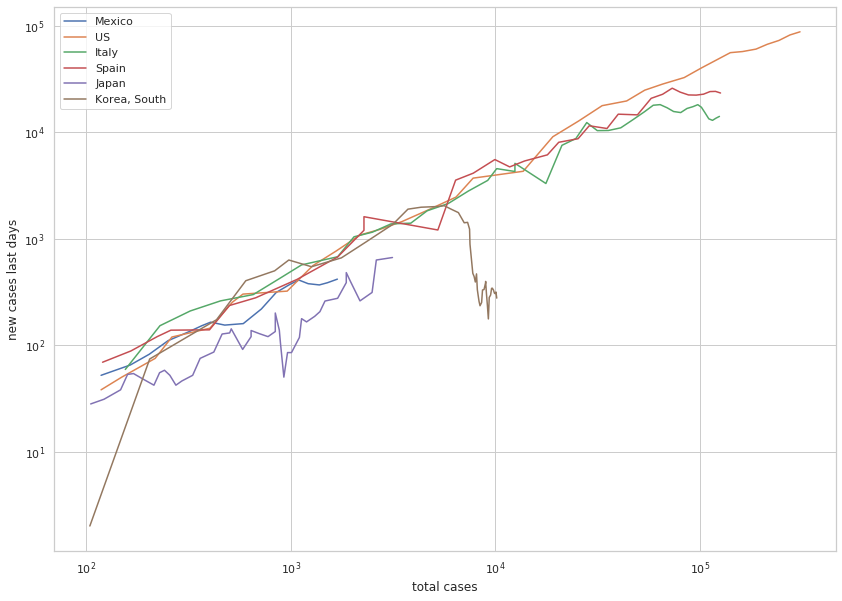

In [15]:
new_per_period = calculate_new_per_period(df_new_per_day, PERIOD=3)
countries = ['Mexico', 'US', 'Italy', 'Spain', 'Japan', 'Korea, South']

#Genius Eric & Aatish: https://aatishb.com/covidtrends/

f, ax = plt.subplots(figsize=(14, 10))
ax.set(yscale="log", xscale="log")
for country in countries:
    cum, new = cum_and_new_from_init(dfw, new_per_period, country)
    plt.plot(cum, new)
plt.legend(countries)
plt.xlabel("total cases")
plt.ylabel("new cases last days")

# México

In [14]:
yesterday = dt.date.today() - dt.timedelta(days=1)
fecha = yesterday #dt.date.today()
df = transform_guzmart(get_guzmart(fecha, force=True))#yesterday
df.head(10)

HTTPError: HTTP Error 404: Not Found

In [ ]:
counts = df["fecha_corte"].value_counts().sort_index()
counts

In [ ]:
f, ax = plt.subplots()#figsize=(14, 10))
#ax.set(yscale="log")
plt.xticks(rotation=45)
p = sns.lineplot(data=counts)

In [ ]:
cum = counts.cumsum()
cum

In [ ]:
plt.xticks(rotation=45)
sns.lineplot(data=cum)

In [ ]:
f, ax = plt.subplots()#figsize=(14, 10))
plt.xticks(rotation=45)
ax.set(yscale="log")
sns.lineplot(data=counts)